---
title: "cross-correlation"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In [10]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime as dt
from scipy import signal
import math
import scipy
import statsmodels.api as sm

from ipywidgets import interact, IntSlider
from IPython.display import display, HTML


# %matplotlib widget

In [11]:
#| code-summary: "create synthetic data"
delta_t = 0.1
time = np.arange(0, 50, delta_t)
N = len(time)
period = 10.0
time_offset = scipy.constants.golden
omega = math.tau / period
signal1 = 3.0 + np.sin(omega*time) + 0.1 * np.random.random(N)
signal2 = -0.5 + 0.2 * np.sin(omega*time - math.tau * (time_offset/period)) + 0.2 * np.random.random(N)

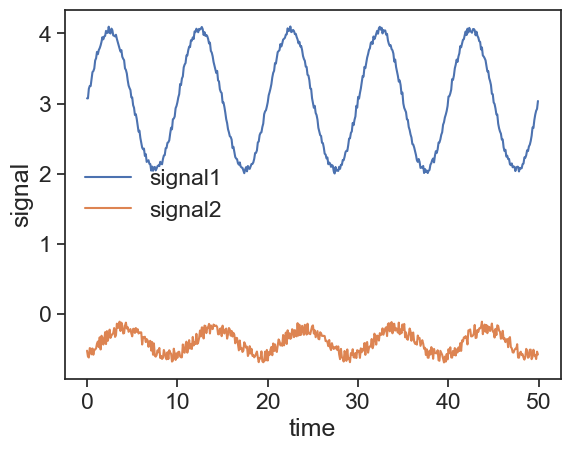

In [12]:
#| code-summary: "plot data"
fig, ax = plt.subplots()
ax.plot(time, signal1, label="signal1")
ax.plot(time, signal2, label="signal2")
ax.set(xlabel="time",
       ylabel="signal")
ax.legend(frameon=False);

Let's standardize our data:

$$
x_n = \frac{x-\mu}{\sigma}.
$$

This is the Z-score we learned before. Effectively, our data now has zero mean and unit standard deviation.

In [13]:
#| code-fold: false
def standardized_data(data):
    # standardize data to have mean=0 and standard_deviation=1
    return (data - data.mean())/ data.std()

s1 = standardized_data(signal1)
s2 = standardized_data(signal2)

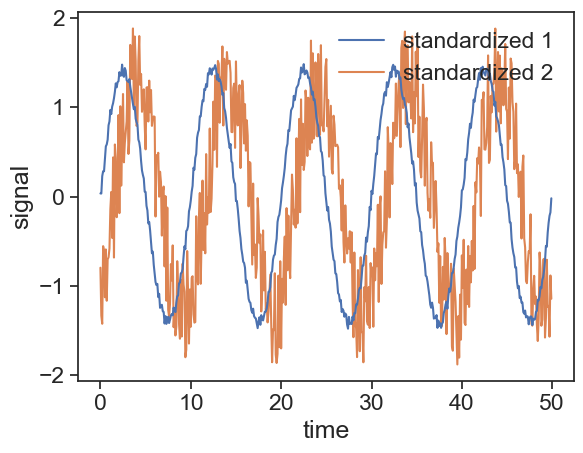

In [14]:
#| code-summary: "plot standardized data"
fig, ax = plt.subplots()
ax.plot(time, s1, label="standardized 1")
ax.plot(time, s2, label="standardized 2", zorder=0)
ax.set(xlabel="time",
       ylabel="signal")
ax.legend(frameon=False)

The definition of cross correlation is very similar to autocorrelation:

$$
\rho_{XY}(\tau) = \frac{E\left[ (X_t - \mu)(Y_{t+\tau} - \mu) \right]}{\sigma_X \sigma_Y}
$$

If the autocorrelation helps us check how similar a signal is to a lagged version of itself, the cross correlation measures how a signal $X$ is similar to a lagged version of another signal $Y$.

Let's write this ourselves:

In [15]:
#| code-fold: false
def cross_corr(s1, s2):
    """
    we assume s1 and s2 to have the same length
    """
    N = len(s1)
    lags_left = np.arange(-(N-1), 1)
    lags_right = np.arange(1, N)
    cc_left = np.array( [np.sum(s2[-i:]*s1[:i]) for i in np.arange(1, len(lags_left)+1)] )
    cc_right = np.array( [np.sum(s2[:-i]*s1[i:]) for i in np.arange(1, len(lags_right)+1)] )
    lags = np.hstack([lags_left, lags_right])
    cc = np.hstack([cc_left, cc_right]) / N
    return lags, cc

Of course, there are available functions that accomplish the same, let's compare them with our code:

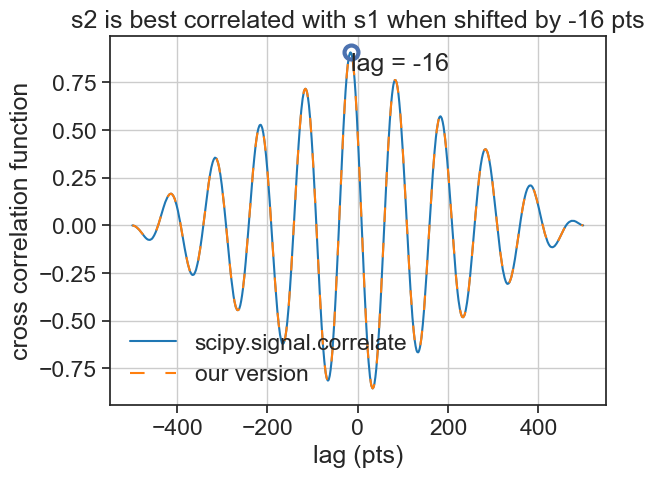

In [16]:
#| code-summary: "cross correlation plot"
corr_np = signal.correlate(s1, s2) / N
lags = signal.correlation_lags(len(s1), len(s2))

my_lag, my_cc = cross_corr(s1, s2)

max_index = np.argmax(corr_np)
fig, ax = plt.subplots()
ax.plot(lags, corr_np, color="tab:blue", label = "scipy.signal.correlate")
ax.plot(my_lag, my_cc, 'tab:orange', dashes=[7, 10], label = "our version")
ax.legend(loc="lower left", frameon=False)

ax.plot([lags[max_index]], [corr_np[max_index]], ls="None", marker="o", mfc="None", mew=3, ms=10)
ax.text(lags[max_index], corr_np[max_index],
        f"lag = {lags[max_index]}", va="top", ha="left")
ax.grid(True)
ax.set(xlabel="lag (pts)",
       ylabel="cross correlation function",
       title=f"s2 is best correlated with s1 when shifted by {lags[max_index]} pts");

In [17]:
#| code-summary: "prepare padded versions of the array"
nann = np.zeros(N) * np.nan
s1_padded = np.hstack([nann, s1, nann])
N_padded = len(s1_padded)
lag_padded = np.arange(N_padded) - N
s2_padded = np.hstack([nann, nann, s2, nann, nann])

In [18]:
#| code-summary: "Widget, should work in VSCode, not on the website"

# Define a function to plot the time series with a shift
def plot_time_series(shift=-500):
    sh = shift + N + 1
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    fig.subplots_adjust(hspace=0.3)  # increase vertical space between panels
    ax[0].plot(lag_padded * delta_t, s1_padded, label="standardized 1")
    ax[0].plot(lag_padded * delta_t, s2_padded[2*N-sh:-sh], label="standardized 2", zorder=0)
    ax[0].set(xlabel="time",
           ylabel="standardized signal",
           xlim=[delta_t*lag_padded.min(), delta_t*lag_padded.max()])
    ax[1].plot(lags, corr_np, color="black", alpha=0.2)
    ax[1].plot(lags[:sh], corr_np[:sh], lw=3, color="xkcd:hot pink")
    ax[1].set(xlabel="lag (pts)",
           ylabel="CCF",
           xlim=[lags.min(), lags.max()],
           ylim=[-1,1])

    plt.show()

# Use interact to create the widget
interact(plot_time_series, shift=IntSlider(min=-500, max=499, step=1, value=-500))

# Add custom CSS to change the length of the slider
display(HTML("""
<style>
.widget-slider {
    width: 100%;
}
</style>
"""))

interactive(children=(IntSlider(value=-500, description='shift', max=499, min=-500), Output()), _dom_classes=(…